In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler



In [46]:
data_path="../data/predictive-maintenance/CMaps/"
# -------------------------------
# 1. Load FD001 data
# -------------------------------
train_file = data_path+"train_FD001.txt"
test_file = data_path+"test_FD001.txt"
rul_file = data_path+"RUL_FD001.txt"
# -------------------------------
# 1. Load data
# -------------------------------
col_names = ['engine_id', 'cycle', 'os1', 'os2', 'os3'] + [f'sensor{i}' for i in range(1, 22)]

train = pd.read_csv(train_file, sep=" ", header=None)
train.dropna(axis=1, how='all', inplace=True)
train.columns = col_names

test = pd.read_csv(test_file, sep=" ", header=None)
test.dropna(axis=1, how='all', inplace=True)
test.columns = col_names

rul = pd.read_csv(rul_file, sep=" ", header=None)
rul.dropna(axis=1, how='all', inplace=True)
rul.columns = ["RUL"]

# -------------------------------
# 2. Compute RUL for TRAIN set
# -------------------------------
rul_train = train.groupby("engine_id")['cycle'].max().reset_index()
rul_train.columns = ["engine_id", "max_cycle"]

train = train.merge(rul_train, on="engine_id", how="left")
train["RUL"] = train["max_cycle"] - train["cycle"]
train.drop("max_cycle", axis=1, inplace=True)

# -------------------------------
# 3. Compute RUL for TEST set
# -------------------------------
rul_test = test.groupby("engine_id")['cycle'].max().reset_index()
rul_test.columns = ["engine_id", "max_cycle"]

# add the additional RUL from RUL_FD001.txt
rul_test["final_RUL"] = rul["RUL"]
rul_test["total_life"] = rul_test["max_cycle"] + rul_test["final_RUL"]

# merge to compute RUL per cycle
test = test.merge(rul_test[["engine_id", "total_life"]], on="engine_id", how="left")
test["RUL"] = test["total_life"] - test["cycle"]
test.drop("total_life", axis=1, inplace=True)

# -------------------------------
# 4. Feature Scaling
# -------------------------------
# Drop useless sensors (constant or near-constant in FD001)
drop_sensors = ["sensor1","sensor5","sensor6","sensor10","sensor16","sensor18","sensor19"]

features = [c for c in train.columns if c not in ["engine_id","cycle","RUL"] + drop_sensors]

scaler = MinMaxScaler()
train_scaled = train.copy()
test_scaled = test.copy()

train_scaled[features] = scaler.fit_transform(train[features])
test_scaled[features] = scaler.transform(test[features])

# -------------------------------
# 5. Final Outputs
# -------------------------------
X_train = train_scaled[features]
y_train = train_scaled["RUL"]

X_test = test_scaled[features]
y_test = test_scaled["RUL"]

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)


Train set: (20631, 17) (20631,)
Test set: (13096, 17) (13096,)


Train MAE: 17.50
Test MAE : 34.67


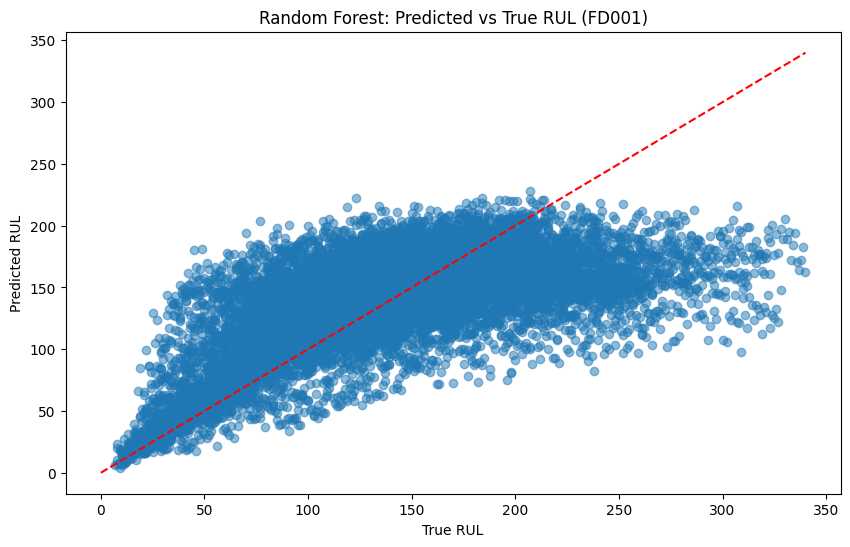

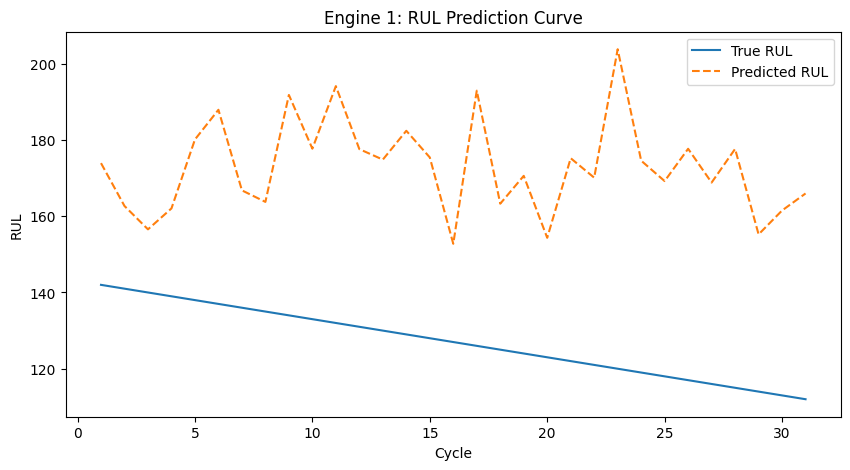

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# -------------------------------
# 1. Train Random Forest
# -------------------------------
rf = RandomForestRegressor(
    n_estimators=200,     # number of trees
    max_depth=15,         # limit depth (avoid overfitting)
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# -------------------------------
# 2. Evaluate
# -------------------------------
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE : {mae_test:.2f}")

# -------------------------------
# 3. Plot Predictions vs True (Test Set)
# -------------------------------
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')  # ideal line
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Random Forest: Predicted vs True RUL (FD001)")
plt.show()

# -------------------------------
# 4. Example: One engine's degradation curve
# -------------------------------
engine_id_to_plot = 1
engine_test = test_scaled[test_scaled["engine_id"] == engine_id_to_plot].copy()

engine_test["RUL_pred"] = rf.predict(engine_test[features])

plt.figure(figsize=(10,5))
plt.plot(engine_test["cycle"], engine_test["RUL"], label="True RUL")
plt.plot(engine_test["cycle"], engine_test["RUL_pred"], label="Predicted RUL", linestyle="--")
plt.xlabel("Cycle")
plt.ylabel("RUL")
plt.title(f"Engine {engine_id_to_plot}: RUL Prediction Curve")
plt.legend()
plt.show()


### Feature Engineering (Sliding Windows / Lag Features)
#### Step A:
The idea: instead of feeding only the current cycle’s sensors, include information from the previous N cycles (e.g., last 10). We can compute:

Mean of each sensor over last N cycles

Standard deviation over last N cycles

Slope / trend (last value − first value in window)

This helps tree models “see” the degradation trend.

In [ ]:
window_size = 10  # number of previous cycles to consider
engine_ids = train['engine_id'].unique()

train_windowed = []
for eid in engine_ids:
    engine_data = train[train['engine_id'] == eid].copy()
    for i in range(window_size, len(engine_data)):
        window = engine_data.iloc[i-window_size:i]
        features_row = {}
        # compute mean, std, slope for each sensor in window
        for s in features:
            features_row[f'{s}_mean'] = window[s].mean()
            features_row[f'{s}_std'] = window[s].std()
            features_row[f'{s}_slope'] = window[s].iloc[-1] - window[s].iloc[0]
        # include cycle info
        features_row['cycle'] = engine_data.iloc[i]['cycle']
        features_row['RUL'] = engine_data.iloc[i]['RUL']
        train_windowed.append(features_row)

train_windowed = pd.DataFrame(train_windowed)
train_windowed.head()

,os1_mean,os1_std,os1_slope,os2_mean,os2_std,os2_slope,os3_mean,os3_std,os3_slope,sensor2_mean,...,sensor17_std,sensor17_slope,sensor20_mean,sensor20_std,sensor20_slope,sensor21_mean,sensor21_std,sensor21_slope,cycle,RUL
0,-0.00135,0.002382,-0.0026,-0.00001,0.000238,0.0005,100.0,0.0,0.0,642.201,...,0.918937,1,38.984,0.070111,-0.11,23.38960,0.044857,0.0504,11.0,181.0
1,-0.00110,0.002580,-0.0001,0.00000,0.000221,0.0000,100.0,0.0,0.0,642.247,...,0.918937,0,38.972,0.065794,-0.06,23.39557,0.052522,0.0551,12.0,180.0
2,-0.00113,0.002543,0.0059,0.00005,0.000201,-0.0001,100.0,0.0,0.0,642.238,...,0.948683,1,38.978,0.071149,0.11,23.38981,0.052264,0.0218,13.0,179.0
3,-0.00089,0.002313,-0.0026,0.00006,0.000217,0.0004,100.0,0.0,0.0,642.310,...,0.816497,1,38.976,0.072296,0.05,23.38296,0.062411,-0.0982,14.0,178.0
4,-0.00087,0.002330,0.0028,0.00006,0.000217,0.0002,100.0,0.0,0.0,642.310,...,0.875595,0,39.006,0.088468,0.28,23.38383,0.062331,-0.0218,15.0,177.0
